# Safe Exploration in Finite Markov Decision Processes with Gaussian Processes

2/8/2023

---

This is a code demo for the paper

M. Turchetta, F. Berkenkamp, A. Krause, "Safe Exploration in Finite Markov Decision Processes with Gaussian Processes", Proc. of the Conference on Neural Information Processing Systems (NIPS), 2016, <a href="http://arxiv.org/abs/1606.04753" target="_blank">[PDF]</a>

corresponding to <a href="https://github.com/befelix/SafeMDP/blob/master/examples/sample.py" target="_blank">this example</a> adapted by Xinran Lian

In [1]:
#import SafeMDP
import safemdp

In [2]:
from __future__ import division, print_function, absolute_import

import time

import GPy
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

from safemdp.utilities import plot_2D
from safemdp.grid_world import (compute_true_safe_set, compute_S_hat0,
                                compute_true_S_hat, draw_gp_sample, GridWorld)

## Define the grid world as GP
### 1. world shape, step size
Shape and step size of the $n \times n$ grid world

### 2. lengthscale
controls ruggedness of the world

In [3]:
# Define world
world_shape = (25, 25)
step_size = (0.5, 0.5)

# Define GP
noise = 0.001
lengthscale = 1.8

In [4]:
kernel = GPy.kern.RBF(input_dim=2, lengthscale=(lengthscale, lengthscale), variance=1.,
                      ARD=True)
lik = GPy.likelihoods.Gaussian(variance=noise ** 2)
lik.constrain_bounded(1e-6, 10000.)

reconstraining parameters Gaussian_noise


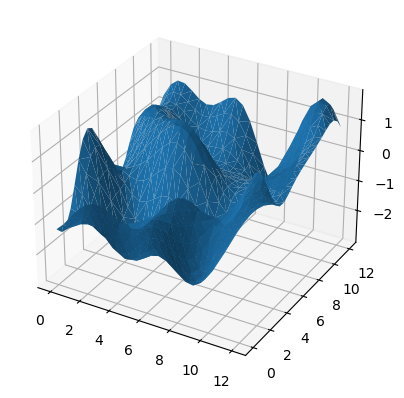

In [5]:
# Sample and plot world
# The ground truth

np.random.seed(102)
altitudes, coord = draw_gp_sample(kernel, world_shape, step_size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(coord[:, 0], coord[:, 1], altitudes)
plt.show()

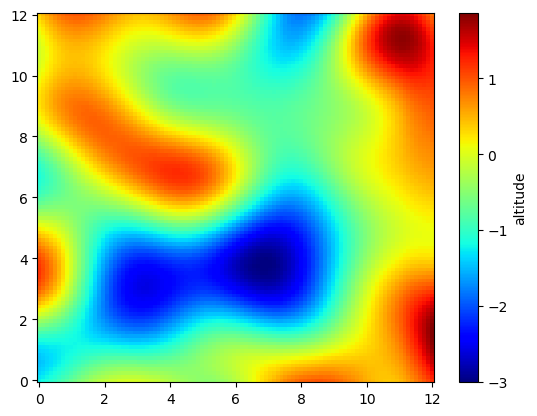

In [6]:
plot_2D(coord,altitudes)

In [7]:
# Define coordinates

n, m = world_shape
step1, step2 = step_size
xx, yy = np.meshgrid(np.linspace(0, (n - 1) * step1, n),
                     np.linspace(0, (m - 1) * step2, m),
                     indexing="ij")

coord = np.vstack((xx.flatten(), yy.flatten())).T

## SafeMDP 

## 0. set-up

### 1) safety threshold h
In section 5 of th paper, the authors described:

"The safety feature over the transition from $s$ to $s'$ is defined in terms of height difference between the two states, $H(s) - H(s')$. Given the maximum slope of $\alpha = 30^\circ$ that the rover can climb, the safety threshold is set at a conservative $h = - d \tan(25^\circ)$."

In the example codes the authors chose $h$ to be -0.25, might be according to $\lim_{x \to 0} \tan x = x$ though  not accurately. Choice of $h$ will affect performance of SafeMDP. 

### 2) L
Lipschitz constant is set as 0

### 3) $\beta$
Selection of $\beta$ is discussed in section 4 of the paper.

In [8]:
# Safety threhsold
h = -0.25 # - np.tan(25*np.pi/360)

# Lipschitz
L = 0

# Scaling factor for confidence interval
beta = 2

## 1. Initialization
Make the first (noisy) observasion

$X = \textbf s_1$

$Y = [r(\textbf s_1) + \omega_1]^T$

In [9]:
# Data to initialize GP

n_samples = 1
ind = np.random.choice(range(altitudes.size), n_samples)

X = coord[ind, :]
Y = altitudes[ind].reshape(n_samples, 1) + np.random.randn(n_samples, 1)

gp = GPy.core.GP(X, Y, kernel, lik)

In [10]:
# Initialize safe sets

S0 = np.zeros((np.prod(world_shape), 5), dtype=bool)
S0[:, 0] = True

# This function will keep re-initializing until find a valid seed
S_hat0 = compute_S_hat0(np.nan, world_shape, 4, altitudes,
                        step_size, h)

In [11]:
# Define SafeMDP object
x = GridWorld(gp, world_shape, step_size, beta, altitudes, h, S0, S_hat0, L)

## 2. Classification

In [12]:
# Insert samples from (s, a) in S_hat0

tmp = np.arange(x.coord.shape[0])
s_vec_ind = np.random.choice(tmp[np.any(x.S_hat[:, 1:], axis=1)])
tmp = np.arange(1, x.S.shape[1])
actions = tmp[x.S_hat[s_vec_ind, 1:].squeeze()]

for i in range(3):
    x.add_observation(s_vec_ind, np.random.choice(actions))

## 3. Iteratively explore the world

In [13]:
# Remove samples used for GP initialization
x.gp.set_XY(x.gp.X[n_samples:, :], x.gp.Y[n_samples:])

t = time.time()
for i in range(100):
    x.update_sets()
    next_sample = x.target_sample()
    x.add_observation(*next_sample)
    
    if i%10==9:
        print("Iteration:   " + str(i+1))

print("%.2f seconds elapsed" %(time.time() - t))

true_S = compute_true_safe_set(x.world_shape, x.altitudes, x.h)
true_S_hat = compute_true_S_hat(x.graph, true_S, x.initial_nodes)

Iteration:   10
Iteration:   20
Iteration:   30
Iteration:   40
Iteration:   50
Iteration:   60
Iteration:   70
Iteration:   80
Iteration:   90
Iteration:   100
2.18 seconds elapsed


## Result

Show results of the safety exploration

predicted safety set

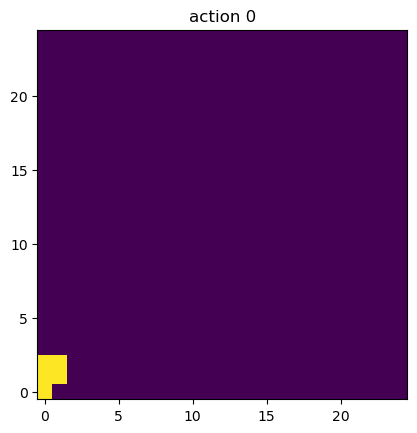

true safety set

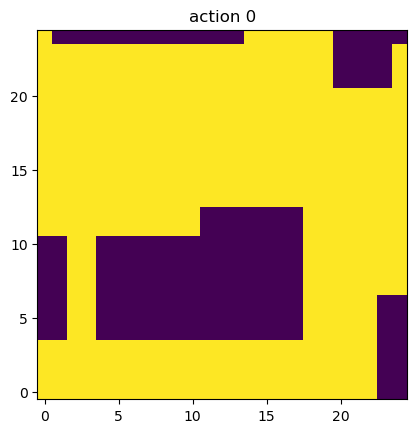

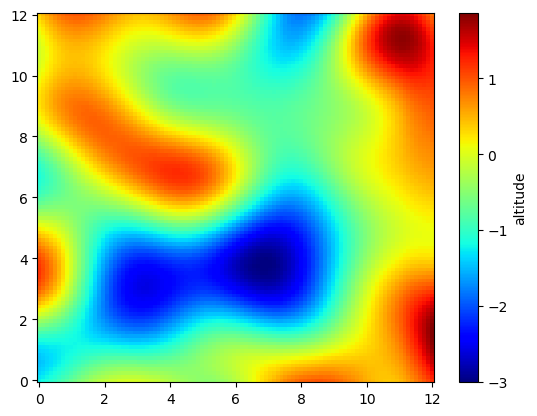

In [14]:
# Plot safe sets

print('predicted safety set', end = '')
x.plot_S(x.S_hat)

print('true safety set', end = '')
x.plot_S(true_S_hat)

plot_2D(coord,altitudes)

In [15]:
# Classification performance
print('Number of unreached safe states (False negative)')
print(np.sum(np.logical_and(true_S_hat, np.logical_not(x.S_hat))))  
# in true S_hat and not S_hat

print('\nNumber of reached unsafe states (False positive)')
print(np.sum(np.logical_and(x.S_hat, np.logical_not(true_S_hat))))
# in  S_hat and not true S_hat

Number of unreached safe states (False negative)
1822

Number of reached unsafe states (False positive)
0
